# Rudiments of Natural Language Processing: Train

This is the second part of the NLP workshop at the Center for Machine Learning. In this notebook we take the IMDB data preprocessed earlier and train a very simple model to classify the movie reviews as positive or negative. We do the following:

*   Gather some prerequisites
*   Load the data
*   Build a very simple model
*   Implement the training loop
*   Train and evaluate the model
*   Explore the word embeddings

## Prerequisites

Before you even start go to the menu above and make sure that your execution environment uses the GPU. Otherwise the model will train very slowly. If you change the environment later you will need to rerun the notebook from the begining. Now install the missing dependencies:

In [ ]:
!pip install portalocker

Import the necessary modules:

In [ ]:
import google.colab as colab
import matplotlib.pyplot as plt
import pickle
import torch
import torchdata
import torchtext

In the previous notebook we saved some data in your home directory on the google drive. To read these data mount your drive:

In [ ]:
colab.drive.mount('/content/drive')

Your home directory is now mounted as `drive/MyDrive`. Check it by listing its contents:

In [ ]:
!ls drive/MyDrive

You should see the files `vocab.pkl`, `train_data.csv` and `valid_data.csv`. If not run the previous notebook to produce them.

## Load the data

Just to remind print the first ten rows of the training CSV file:

In [ ]:
!head drive/MyDrive/train_data.csv

Each row represents one review. The first column contains the classification label which is 0 or 1 for negative or positive reviews respectively. The next columns contain indices of subsequent words in a review according to the vocabulary. We will be loading these data using datapipes which will soon become a new standard in pytorch but are now in beta phase so you may encounter some problems. Create a datapipe that reads rows from the training CSV file:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()

This datapipe yields the rows as lists of text strings that actually contain numbers:

In [ ]:
for sample in train_pipe.header(10):
    print(sample)

Consume this datapipe so that the label and word indices are unpacked to separate variables:

In [ ]:
for label0, *index1 in train_pipe.header(10):
    print(label0, index1)

Now write a separate `decode` function that does the unpacking:

In [ ]:
def decode(sample):
    label0, *index1 = sample
    return label0, index1

Apply this function to each row yielded by the datapipe by mapping it onto the datapipe:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)

This new datapipe directly yields tuples of labels and indices:

In [ ]:
for label0, index1 in train_pipe.header(10):
    print(label0, index1)

Let the `decode` function also convert the labels and indices from text strings to float and integer numbers respectively:

In [ ]:
def decode(sample):
    label0, *index1 = sample
    label0 = float(label0)
    index1 = [int(index0) for index0 in index1]
    return label0, index1

Reinstantiate the datapipe with the new `decode` function and test it:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)

for label0, index1 in train_pipe.header(10):
    print(label0, index1)

Let the `decode` function also convert the indices from python lists to pytorch tensors:

In [ ]:
def decode(sample):
    label0, *index1 = sample
    label0 = float(label0)
    index1 = torch.tensor([int(index0) for index0 in index1])
    return label0, index1

Reinstantiate the datapipe and test it:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)

for label0, index1 in train_pipe.header(10):
    print(label0, index1)

The reviews in the CSV files are preliminary shuffled but it is best to consume them in different order during each epoch of training. Shuffle the datapipe and a different random shuffling will be applied in each epoch:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)

for label0, index1 in train_pipe.header(10):
    print(label0, index1)

The datapipe yields tuples of labels and indices. To explicitly see these tuples consume the datapipe without unpacking:

In [ ]:
for sample in train_pipe.header(10):
    print(sample)

Training is usually done in batches. Let the datapipe yield batches and set the batch size to two just for illustration:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)
train_pipe = train_pipe.batch(2)

for batch in train_pipe.header(10):
    print(batch)

Each yielded batch is now a list containing tuples. But training requires that labels and indices are yielded separately. Define a function `collate` that unzips the yielded list of tuples into a tuple containing all labels in the batch and separately all indices in the batch:

In [ ]:
def collate(batch):
    label1, index2 = zip(*batch)
    return label1, index2

This function could be applied to the datapipe using the ordinary mapping. But there is an equivalent `collate` operation whose name emphasizes that a custom collation of reviews into batches is performed:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)
train_pipe = train_pipe.batch(2)
train_pipe = train_pipe.collate(collate)

for batch in train_pipe.header(10):
    print(batch)

Strictly speaking each yielded batch is now a tuple of two tuples. The first inner tuple contains labels of all reviews in the batch and the second inner tuple contains word indices of all reviews in the batch. Consume this datapipe by unpacking the outer tuple into labels and indices:

In [ ]:
for label1, index2 in train_pipe.header(10):
    print(label1)
    print(index2)

The labels are now yielded as an ordinary python tuple. Let the `collate` function convert this tuple to a pytorch tensor:

In [ ]:
def collate(batch):
    label1, index2 = zip(*batch)
    label1 = torch.tensor(label1)
    return label1, index2

Reinstantiate the datapipe with the new `collate` function and test it:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)
train_pipe = train_pipe.batch(2)
train_pipe = train_pipe.collate(collate)

for label1, index2 in train_pipe.header(10):
    print(label1)
    print(index2)

The word indices of all reviews in the batch are now yielded as a tuple of one-dimensional pytorch tensors. Training requires that it is converted to a two-dimensional tensor whose rows correspond to subsequent reviews in the batch and columns to subsequent words in each review. But the problem here is that different reviews in the same batch have different lenghts. So the shorter reviews will be padded with zeros to reach the length of the longest review in the batch. Recall that zero is the word index of the special word `<pad>`. The padding is done using a dedicated pytorch function:

In [ ]:
def collate(batch):
    label1, index2 = zip(*batch)
    label1 = torch.tensor(label1)
    index2 = torch.nn.utils.rnn.pad_sequence(index2, padding_value = 0, batch_first = True)
    return label1, index2

Reinstantiate the datapipe and test it:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)
train_pipe = train_pipe.batch(2)
train_pipe = train_pipe.collate(collate)

for label1, index2 in train_pipe.header(10):
    print(label1)
    print(index2)

Now one row of each two-dimensional index tensor is always padded with zeros at the end. Change the batch size to the value of 64 that we will actually use:

In [ ]:
train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)
train_pipe = train_pipe.batch(64)
train_pipe = train_pipe.collate(collate)

This is the final version of our training datapipe. Print the shapes of some initial batches and note how different batches have different sizes in the second dimension corresponding to the review length:

In [ ]:
for label1, index2 in train_pipe.header(10):
    print(index2.size())

Build a corresponding datapipe for validation data. Note that validation data does not require shuffling:

In [ ]:
valid_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/valid_data.csv'])
valid_pipe = valid_pipe.parse_csv()
valid_pipe = valid_pipe.map(decode)
valid_pipe = valid_pipe.batch(64)
valid_pipe = valid_pipe.collate(collate)

## Build a simple model

We will now build a model to classify the reviews. As input the model takes a padded batch of word indices as yielded by our datapipes. Just to remind how models are constructed in pytorch start with a trivial one that simply returns these indices without any change:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
    def forward(self, index): #(samples, frames)
        return index

model = Model()

In the comment we denoted the shape of the input index tensor as `(samples, frames)` where `samples` is the number of reviews in the batch and `frames` is the number of words in each review padding included. The output obviously has the same shape. Feed a few batches to this model and print the input and output shapes:

In [ ]:
for label, index in valid_pipe.header(10):
    print(index.size())
    index = model(index)
    print(index.size())
    print()

We will soon need the number of unique words in the vocabulary. Read the vocabulary from the pickle file on your google drive and store its length in a variable called `indices`:

In [ ]:
with open('drive/MyDrive/vocab.pkl', 'rb') as stream:
    vocab = pickle.load(stream)

indices = len(vocab)

To each unique word in the vocabulary we will assign a real-valued vector that is called a word embedding because it embeds a word in multi-dimensional space. Elements of this vector are called features and we denote their number as `features`. In real-world models the embeddings have hundreds of dimensions but here we limit ourselves to four: 

In [ ]:
features = 4

The embeddings will be learned from data together with the model. They are in fact part of the model and are stored in a special embedding layer. When constructing this layer we pass the number of unique words in the vocabulary `indices` and the requested embedding size `features`:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
    def forward(self, index):         #(samples, frames)
        feature = self.encoder(index) #(samples, frames, features)
        return feature

model = Model()

The embedding layer is just a lookup table. It takes a word index and returns its corresponding embedding vector. It can also take any multidimensional tensor of word indices and return their embeddings elementwise. The embedding size is added to the input tensor shape as the last dimension. In our model the embedding layer is the first or input one. It takes a batch of word indices and produces a batch of embeddings. Pass a few batches to this model and print the shapes of input indices and output embeddings:

In [ ]:
for label, index in valid_pipe.header(10):
    print(index.size())
    feature = model(index)
    print(feature.size())
    print()

The embedding features are trainable parameters of the Embedding layer and thus become trainable parameters of the whole model. They are determined during training via backpropagation together with all the remaining parameters of the model. The output of the embedding layer contains embeddings of all words in a review. But we want to classify the review as a whole. Therefore the embeddings of all the component words must be somehow aggregated into a single set of features describing the whole review. In our simple model we just take the arithmetic mean of all the word embeddings in each review separately:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
    def forward(self, index):         #(samples, frames)
        feature = self.encoder(index) #(samples, frames, features)
        feature = feature.mean(1)     #(samples, features)
        return feature

model = Model()

Note that the mean does not depend on the order of words in a review so in this way we loose all information about word order. Inspect the input and output shapes for a few batches:

In [ ]:
for label, index in valid_pipe.header(10):
    print(index.size())
    feature = model(index)
    print(feature.size())
    print()

Now that the number of average features is fixed and a priori known so we can pass these features to a simple linear layer that will produce logits for later classification:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):            #(samples, frames)
        feature = self.encoder(index)    #(samples, frames, features)
        feature = feature.mean(1)        #(samples, features)
        logit = self.classifier(feature) #(samples, 1)
        return logit

model = Model()

The classification layer outputs just one logit because we will use the formalism of binary classification. Print the input and output shapes for a few batches:

In [ ]:
for label, index in valid_pipe.header(10):
    print(index.size())
    logit = model(index)
    print(logit.size())
    print()

For technical reasons it will be convenient to get rid of the singleton dimension of the logits. Do it by flattening the logits:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):            #(samples, frames)
        feature = self.encoder(index)    #(samples, frames, features)
        feature = feature.mean(1)        #(samples, features)
        logit = self.classifier(feature) #(samples, 1)
        logit = logit.flatten()          #(samples)
        return logit

model = Model()

Print some input and output shapes again:

In [ ]:
for label, index in valid_pipe.header(10):
    print(index.size())
    logit = model(index)
    print(logit.size())
    print()

## Calculate prediction accuracy

The model has not been trained yet but it is technically usable already. The model yields logits also known as unnormalized probability scores. Print some of them:

In [ ]:
for truth_label, index in valid_pipe.header(10):
    logit = model(index)
    print(logit)

A newly initialized model often gives logits of one sign only but this will change during trainig. A negative or positive logit means that the corresponding review is classified as negative or positive respectively. Construct the predicted labels accordingly:

In [ ]:
for truth_label, index in valid_pipe.header(10):
    logit = model(index)
    model_label = logit.gt(0).float()
    print(model_label)

Compare the predicted labels against the ground-true ones to check if the model has hit the correct labels:

In [ ]:
for truth_label, index in valid_pipe.header(10):
    logit = model(index)
    model_label = logit.gt(0).float()
    hit = model_label.eq(truth_label)
    print(hit)

The prediction accuracy is the number of correcly predicted labels divided by the total number of predictions. Calculate and print the accuracy separately for each batch:

In [ ]:
for truth_label, index in valid_pipe.header(10):
    logit = model(index)
    model_label = logit.gt(0).float()
    hit = model_label.eq(truth_label)
    accuracy = hit.count_nonzero() / hit.numel()
    print(accuracy)

To calculate the accuracy in the whole dataset sum the correct and total predictions over batches and then divide:

In [ ]:
valid_accuracy = torch.tensor(0)
samples = torch.tensor(0)
for truth_label, index in valid_pipe:
    logit = model(index)
    model_label = logit.gt(0).float()
    hit = model_label.eq(truth_label)
    valid_accuracy += hit.count_nonzero()
    samples += hit.numel()
valid_accuracy = valid_accuracy / samples
print(valid_accuracy)

This accuracy is close to 0.5 but not because an untrained model gives random predictions. We have already seen that a newly initialized model usually puts most reviews into the same class. So the accuracy is close to 0.5 because half of the reviews are actually negative and half are positive. Instead of printing the ccuracy as a pytorch tensor extract its only value and print it as an ordinary python number:

In [ ]:
print(valid_accuracy.item())

Format this printout to three digits:

In [ ]:
print('%5.3f' % valid_accuracy)

## Train and evaluate the model

We will now train the model on the training data and evaluate it on both the training and validation data. Start with this code that iterates in batches over both datasets and calculates the prediction accuracy for each of them:

In [ ]:
valid_accuracy = torch.tensor(0)
samples = torch.tensor(0)
for truth_label, index in valid_pipe:
    logit = model(index)
    model_label = logit.gt(0).float()
    hit = model_label.eq(truth_label)
    valid_accuracy += hit.count_nonzero()
    samples += hit.numel()
valid_accuracy = valid_accuracy / samples
train_accuracy = torch.tensor(0)
samples = torch.tensor(0)
for truth_label, index in train_pipe:
    logit = model(index)
    model_label = logit.gt(0).float()
    hit = model_label.eq(truth_label)
    train_accuracy += hit.count_nonzero()
    samples += hit.numel()
train_accuracy = train_accuracy / samples
print('%5.3f %5.3f' % (train_accuracy, valid_accuracy))

For each batch of the training data calculate the binary cross entropy as the loss value calculate its gradients by automatic differentiation and perform a minimization step by using an optimizer that we choose to be Adam:

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
valid_accuracy = torch.tensor(0)
samples = torch.tensor(0)
for truth_label, index in valid_pipe:
    logit = model(index)
    model_label = logit.gt(0).float()
    hit = model_label.eq(truth_label)
    valid_accuracy += hit.count_nonzero()
    samples += hit.numel()
valid_accuracy = valid_accuracy / samples
train_accuracy = torch.tensor(0)
samples = torch.tensor(0)
for truth_label, index in train_pipe:
    logit = model(index)
    model_label = logit.gt(0).float()
    hit = model_label.eq(truth_label)
    train_accuracy += hit.count_nonzero()
    samples += hit.numel()
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
train_accuracy = train_accuracy / samples
print('%5.3f %5.3f' % (train_accuracy, valid_accuracy))

The training accuracy is a bit higher now because some learning has already been done. One iteration through the entire training set is called an epoch. Perform a reasonable number of epochs. These calculations may be quite slow so stop the execution of this cell at any time:

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
for epoch in range(128):
    valid_accuracy = torch.tensor(0)
    samples = torch.tensor(0)
    for truth_label, index in valid_pipe:
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    train_accuracy = torch.tensor(0)
    samples = torch.tensor(0)
    for truth_label, index in train_pipe:
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

To later plot the training and vaidation accuracy store their values from every epoch in a list:

In [ ]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
for epoch in range(128):
    valid_accuracy = torch.tensor(0)
    samples = torch.tensor(0)
    for truth_label, index in valid_pipe:
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    train_accuracy = torch.tensor(0)
    samples = torch.tensor(0)
    for truth_label, index in train_pipe:
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

The goal of training is to obtain a model with maximum accuracy on the validation data. Save the model to disk whenever the validation accuracy increases:

In [ ]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.)
for epoch in range(128):
    valid_accuracy = torch.tensor(0)
    samples = torch.tensor(0)
    for truth_label, index in valid_pipe:
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'model.pt')
    train_accuracy = torch.tensor(0)
    samples = torch.tensor(0)
    for truth_label, index in train_pipe:
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

We will soon use the saved model to examine its properties. If you want to save the model permanently change the target folder to your google drive. To speed up the calculations perform them on GPU. To do this you need a GPU-enabled execution environment. If you have not set it at the start do it now and rerun the notebook from the very beginning. Create the model once again and move it to GPU:

In [ ]:
model = Model().cuda()

Move all the tensors in the training loop to GPU. Unfortunately the free colab GPUs are quite slow so instead of running the code you can display the hidden output preparred earlier. If you want to train the model yourself execute the cell without interruption:

In [ ]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.).cuda()
for epoch in range(128):
    valid_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in valid_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'model.pt')
    train_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in train_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

    0 0.539 0.500
    1 0.683 0.650
    2 0.735 0.715
    3 0.775 0.717
    4 0.792 0.769
    5 0.811 0.792
    6 0.824 0.803
    7 0.837 0.814
    8 0.849 0.821
    9 0.858 0.837
   10 0.866 0.847
   11 0.873 0.853
   12 0.880 0.858
   13 0.883 0.863
   14 0.888 0.865
   15 0.891 0.870
   16 0.893 0.871
   17 0.896 0.876
   18 0.899 0.879
   19 0.901 0.880
   20 0.903 0.881
   21 0.905 0.885
   22 0.908 0.887
   23 0.910 0.889
   24 0.912 0.889
   25 0.914 0.891
   26 0.915 0.892
   27 0.917 0.890
   28 0.919 0.892
   29 0.920 0.892
   30 0.922 0.894
   31 0.924 0.895
   32 0.925 0.896
   33 0.927 0.897
   34 0.928 0.897
   35 0.930 0.898
   36 0.931 0.899
   37 0.933 0.900
   38 0.934 0.900
   39 0.934 0.900
   40 0.935 0.899
   41 0.937 0.900
   42 0.938 0.900
   43 0.939 0.901
   44 0.940 0.901
   45 0.940 0.900
   46 0.942 0.902
   47 0.943 0.902
   48 0.944 0.903
   49 0.945 0.903
   50 0.946 0.902
   51 0.947 0.902
   52 0.947 0.903
   53 0.949 0.903
   54 0.950 0.905
   55 0.95

The validation accuracy should reach 90% This is very good given that we use only four embedding features and a trivial model that completely neglects the order of words. To obtain higher accuracy it is necessary to use a more complex model and pretrain it on a much larger corpus of text. Models trained only on the IMDB dataset usually achieve validation accuracy lower than 90% so worse than this trivial one. To plot the accuracies unzip the training history into three lists:

In [ ]:
epoch, train_accuracy, valid_accuracy = zip(*history)

Now make the plot:

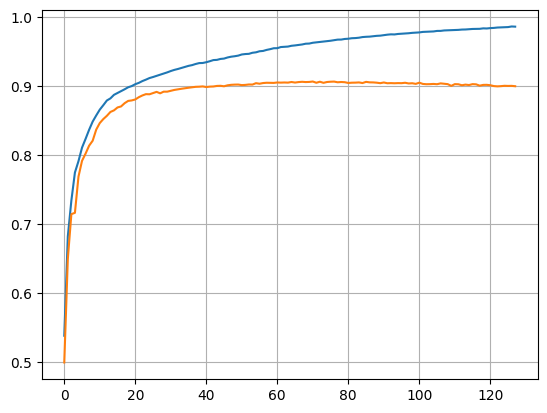

In [ ]:
plt.grid()
plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)

The training accuracy only grows and would eventually reach 100% The validation accuracy attains a maximum of about 90% and then drops. This is a typical behavior due to overfitting.

## Explore the embeddings

Let us now see what happens if we reduce the number of embedding features to one:

In [ ]:
features = 1

Construct and instantiate the model:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):            #(samples, frames)
        feature = self.encoder(index)    #(samples, frames, features)
        feature = feature.mean(1)        #(samples, features)
        logit = self.classifier(feature) #(samples, 1)
        logit = logit.flatten()          #(samples)
        return logit

model = Model().cuda()

Train it:

In [ ]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.).cuda()
for epoch in range(128):
    valid_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in valid_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'model.pt')
    train_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in train_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

    0 0.509 0.500
    1 0.520 0.501
    2 0.540 0.511
    3 0.558 0.528
    4 0.587 0.547
    5 0.634 0.589
    6 0.672 0.618
    7 0.731 0.707
    8 0.754 0.730
    9 0.768 0.745
   10 0.783 0.764
   11 0.787 0.771
   12 0.795 0.779
   13 0.803 0.782
   14 0.809 0.791
   15 0.817 0.797
   16 0.823 0.802
   17 0.831 0.808
   18 0.836 0.810
   19 0.843 0.818
   20 0.849 0.825
   21 0.854 0.831
   22 0.859 0.838
   23 0.864 0.842
   24 0.868 0.846
   25 0.872 0.849
   26 0.876 0.854
   27 0.879 0.855
   28 0.881 0.858
   29 0.884 0.861
   30 0.886 0.863
   31 0.888 0.866
   32 0.890 0.866
   33 0.892 0.869
   34 0.894 0.870
   35 0.895 0.871
   36 0.896 0.873
   37 0.898 0.875
   38 0.900 0.877
   39 0.901 0.878
   40 0.902 0.879
   41 0.903 0.881
   42 0.904 0.882
   43 0.905 0.881
   44 0.908 0.883
   45 0.909 0.883
   46 0.910 0.885
   47 0.911 0.885
   48 0.912 0.886
   49 0.913 0.887
   50 0.913 0.888
   51 0.915 0.888
   52 0.916 0.888
   53 0.917 0.890
   54 0.918 0.890
   55 0.91

Plot the accuracies:

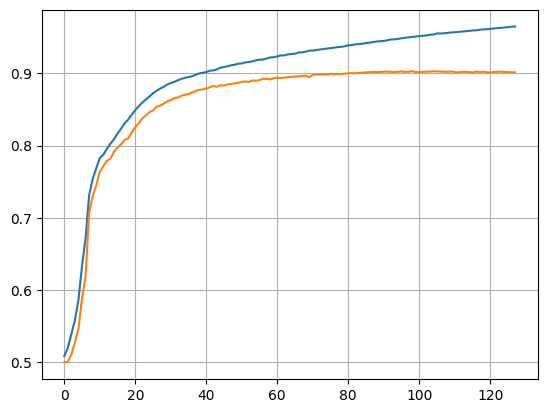

In [ ]:
epoch, train_accuracy, valid_accuracy = zip(*history)

plt.grid()
plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)

Compare the two plots. Now the model has less parameters and learns slower on the training data. Yet for the same reason there is less overfitting so the validation accuracy is roughly the same and about 90% Since we achieve the same 90% accuracy with only one embedding feature it should be already clear what the model actually does... It assigns positive embeddings to positive words and negative embeddings to negative words or vice versa. Then it calculates a mean off all the embeddings in a review. To check it move the modem to CPU and load the recordered parameters:

In [ ]:
model = model.cpu()
model.load_state_dict(torch.load('model.pt'))

In this way we load the parameters from the epoch when the model performed best on the validation data. Get the list of unique words in the vocabulary:

In [ ]:
itos = vocab.get_itos()

Now iterate through some initial word indices. For each index get the corresponding word from the list. Also pass the index to the embedding layer and get the corresponding feature. Print them:

In [ ]:
for index in range(1024):
    print('%5i %16s %7.3f' % (index, itos[index], model.encoder(torch.tensor([[index]]))))

    0            <pad>  -0.037
    1            <unk>   1.018
    2              the  -0.232
    3              and  -0.859
    4                a   0.112
    5               of  -0.007
    6               to   0.725
    7               is  -1.023
    8               in  -0.258
    9               it  -2.203
   10                i  -0.450
   11             this   1.371
   12             that   0.092
   13              was   1.804
   14               as  -0.123
   15             with  -0.434
   16              for   0.151
   17            movie  -0.608
   18              but   0.494
   19             film  -0.831
   20               on   0.674
   21              not   3.025
   22              you  -4.050
   23              are   0.729
   24              his  -0.828
   25             have   1.727
   26               be   0.661
   27              one  -0.460
   28               he  -1.998
   29              its  -2.738
   30              all  -0.205
   31               at   0.225
   32   

Note that emotionally negative words like *bad* have large embeddings of one sign while positive words like *great* have large embeddings of the opposite sign which is expected. However some neutral words like *minutes* also have large embeddings. This occurs when such a neutral word happens to appear only in negative or only in positive training reviews. Then the model thinks that it is negative or positive respectively. This is one cause of overfitting. Now proceed to the next notebook and introduce the attention mechanism to our model.